<a href="https://www.kaggle.com/code/riyosha/mushroom-binary-prediction-0-984-mcc?scriptVersionId=193177363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.impute import SimpleImputer

In [ ]:
# TargetEncoder
!pip install -q scikit-learn==1.4
# KerasClassifier
!pip install -q --no-deps scikeras
# Original dataset
!pip install -q ucimlrepo


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import datetime
from colorama import Fore, Style
import lightgbm
import xgboost
import catboost
from scikeras.wrappers import KerasClassifier
import keras
from ucimlrepo import fetch_ucirepo 
import scipy.special

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, PolynomialFeatures, QuantileTransformer, TargetEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score, log_loss, ConfusionMatrixDisplay, confusion_matrix

ImportError: cannot import name '_fit_context' from 'sklearn.base' (/opt/conda/lib/python3.10/site-packages/sklearn/base.py)

# Exploratory Data Analysis

In [3]:
data_path = '/kaggle/input/playground-series-s4e8'
train = pd.read_csv(data_path+'/train.csv')
test = pd.read_csv(data_path+'/test.csv')
samplesubmission = pd.read_csv(data_path+'/sample_submission.csv')

In [3]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [4]:
test.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [34]:
print(train.shape)
print(train.columns)
print('Test to Train ratio: ', test.shape[0]/train.shape[0])
print(train.describe(include='all'))

(3116941, 17)

Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',

       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',

       'stem-height', 'stem-width', 'stem-color', 'has-ring', 'ring-type',

       'habitat', 'season'],

      dtype='object')

Test to Train ratio:  0.666667736091251

                  id    class  cap-diameter cap-shape cap-surface cap-color  \

count   3.116941e+06  3116941  3.116941e+06   3116941     3116941   3116941   

unique           NaN        2           NaN        24          24        24   

top              NaN        p           NaN         x     missing         n   

freq             NaN  1705393           NaN   1436028      671085   1359542   

mean    1.558471e+06      NaN  6.309848e+00       NaN         NaN       NaN   

std     8.997846e+05      NaN  4.657931e+00       NaN         NaN       NaN   

min     0.000000e+00      NaN  3.000000e-02       NaN         NaN       NaN   

25%     7.7923

In [125]:
samplesubmission.head()

,id,class
0,3116945,e
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


# Missing/Wrong Values

In [32]:
print('Rows with at least 1 missing value: ', train.isna().any(axis=1).sum())
print(train.isna().sum())
print(test.isna().sum())
# almost all rows have at least 1 missing values, however,
# stem-root, stem-surface, veil-type, veil-color,spore-print-color have > 50% missing values in both test and train sets. 
# we can drop these features, assuming they are MCAR or MAR. we'll use PPS to decide whether they stay later

Rows with at least 1 missing value:  3116945

id                            0

class                         0

cap-diameter                  4

cap-shape                    40

cap-surface              671023

cap-color                    12

does-bruise-or-bleed          8

gill-attachment          523936

gill-spacing            1258435

gill-color                   57

stem-height                   0

stem-width                    0

stem-root               2757023

stem-surface            1980861

stem-color                   38

veil-type               2957493

veil-color              2740947

has-ring                     24

ring-type                128880

spore-print-color       2849682

habitat                      45

season                        0

dtype: int64

id                            0

cap-diameter                  7

cap-shape                    31

cap-surface              446904

cap-color                    13

does-bruise-or-bleed         10

gill-attachment 

In [5]:
#let's turn numeric columns to the numeric dtype
train['id']=pd.to_numeric(train['id'])
train['cap-diameter']=pd.to_numeric(train['cap-diameter'])
train['stem-height']=pd.to_numeric(train['stem-height'])
train['stem-width']=pd.to_numeric(train['stem-width'])

many values in the categorical columns have entries that don't make sense (numbers or phrases)

In [90]:
#train = train.drop(columns=['stem-root','stem-surface','veil-type','veil-color','spore-print-color'])

for col in train.columns:
    print(col, ':', train[col].unique())


id : [      0       1       2 ... 3116942 3116943 3116944]

class : ['e' 'p']

cap-diameter : [ 8.8   4.51  6.94 ... 38.11 55.63 54.07]

cap-shape : ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'

 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'

 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'

 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'

 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'

 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'

 '4.33' '2.82' '6.53' '19.06']

cap-surface : ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'

 'a' 'u' 'z' '2.7' 'does l' '5.07' 'p' 'b' 'm' 'cap-diameter' '1.43' 'x'

 '7.14' 'c' 'is h' 'does t' '0.85' '6.57' '12.79' '6.45' '4.66' '23.18'

 '3.06' '16.39' '4.21' 'veil-color' '11.78' '8.1' 'has-ring' 'does h'

 '1.42' 'class' 'has h' 'does None' '10.83' 'season' '8.96' '14.04' '5.

There also many nonsensical categories in the columns. This is the description of the categories that are supposed to be in the df. We'll remove categories and entries outside these
1. cap-diameter (m): float number in cm
2. cap-shape (n): bell=b, conical=c, convex=x, flat=f,
sunken=s, spherical=p, others=o
3. cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s,
shiny=h, leathery=l, silky=k, sticky=t,
wrinkled=w, fleshy=e
4. cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p,
purple=u, red=e, white=w, yellow=y, blue=l,
orange=o, black=k
5. does-bruise-bleed (n): bruises-or-bleeding=t,no=f
6. gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e,
sinuate=s, pores=p, none=f, unknown=?
7. gill-spacing (n): close=c, distant=d, none=f
8. gill-color (n): see cap-color + none=f
9. stem-height (m): float number in cm
10. stem-width (m): float number in mm
11. stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e,
rhizomorphs=z, rooted=r
12. stem-surface (n): see cap-surface + none=f
13. stem-color (n): see cap-color + none=f
14. veil-type (n): partial=p, universal=u
15. veil-color (n): see cap-color + none=f
16. has-ring (n): ring=t, none=f
17. ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g,
large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
18. spore-print-color (n): see cap color
19. habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h,
urban=u, waste=w, woods=d
20. season (n): spring=s, summer=u, autumn=a, winter=w

In [8]:
# treating nonsensical categories and missing values
categories = {
    'cap-shape': ['b', 'c', 'x', 'f', 's', 'p', 'o'],
    'cap-surface': ['i', 'g', 'y', 's', 'h', 'l', 'k', 't', 'w', 'e'],
    'cap-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k'],
    'does-bruise-or-bleed': ['t', 'f'],
    'gill-attachment': ['a', 'x', 'd', 'e', 's', 'p', 'f', '?'],
    'gill-spacing': ['c', 'd', 'f'],
    'gill-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
    'stem-root': ['b', 's', 'c', 'u', 'e', 'z', 'r'],
    'stem-surface': ['i', 'g', 'y', 's', 'h', 'l', 'k', 't', 'w', 'e', 'f'],  # Same as cap-surface plus 'f'
    'stem-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
    'veil-type': ['p', 'u'],
    'veil-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
    'has-ring': ['t', 'f'],
    'ring-type': ['c', 'e', 'r', 'g', 'l', 'p', 's', 'z', 'y', 'm', 'f', '?'],
    'spore-print-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k'],  # Same as cap-color
    'habitat': ['g', 'l', 'm', 'p', 'h', 'u', 'w', 'd'],
    'season': ['s', 'u', 'a', 'w']
}

import re
# function to deal with missing and nonsensical values
def clean_cats(string):
    if pd.isna(string):
        return 'missing'
    elif type(string)!=str:
        return 'missing'
    ans=None
    words=string.split()
    for word in words:
        word = re.sub(r'[^a-zA-Z?]', '', word)
        if len(word)==1:
            ans=word
    if ans == None or ans=='':
        ans='missing'
    return ans

In [9]:
processed_train=train
for col in processed_train.columns:
    if processed_train[col].dtype==object and col!='class':
        main_cats = categories[col]+['missing']
        processed_train[col]=processed_train[col].apply(lambda x: clean_cats(x))
        processed_train[col]=processed_train[col].apply(lambda x: x if x in main_cats else 'noise')
        processed_train[col]=processed_train[col].astype('category')
     

we're left with 4 columns with missing values. We can fill them using knn imputer

In [14]:
print('Rows with at least 1 missing value: ', processed_train.isna().any(axis=1).sum())
print(processed_train.isna().sum())

Rows with at least 1 missing value:  4
id                      0
class                   0
cap-diameter            4
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64


In [15]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

imputer = KNNImputer(n_neighbors=2)  # Adjust n_neighbors as needed
processed_train['cap-diameter']=imputer.fit_transform(processed_train[['cap-diameter']])


I've chosen not to impute or replace missing values as my model seemed to perform marginally better when it simply used the missing category instead 

Finding significant features

In [16]:
from scipy.stats import chi2_contingency

# finds if feature is related to class
def significant_features(df, target='class',alpha=0.05):
    ans={}
    for col in df.columns:
        if col!=target and df[col].dtype == 'category' or df[col].dtype == object:
            contingency_table = pd.crosstab(df[target],df[col])
            chi2, p,_,_ = chi2_contingency(contingency_table)
            if p<alpha:
                ans[col] = p
                print(f'{col} has p-value {p}')
    return ans

In [17]:
# make sure our columns are categories
for col in processed_train.columns:
    if processed_train[col].dtype==object:

        processed_train[col]=processed_train[col].astype('category')

In [19]:
sig_features=significant_features(processed_train)

sig_features=list(sig_features.keys())+['cap-diameter','stem-width','stem-height','class']
processed_train=processed_train[sig_features]


cap-shape has p-value 0.0
cap-surface has p-value 0.0
cap-color has p-value 0.0
does-bruise-or-bleed has p-value 0.0
gill-attachment has p-value 0.0
gill-spacing has p-value 0.0
gill-color has p-value 0.0
stem-root has p-value 0.0
stem-surface has p-value 0.0
stem-color has p-value 0.0
veil-type has p-value 0.0
veil-color has p-value 0.0
has-ring has p-value 0.0
ring-type has p-value 0.0
spore-print-color has p-value 0.0
habitat has p-value 0.0
season has p-value 0.0


# Models

the crossvalidation and models code is taken from @AmbrosM's notebook: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense#Cross-validation

In [37]:
from sklearn.model_selection import StratifiedKFold
import datetime
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import log_loss
from colorama import Fore, Style

In [38]:
target = processed_train.pop('class')
targets_bool = target == 'p'

KeyError: 'class'

In [41]:
# Configuration
# Produce a submission file (you can set this to false if you only
# want to see the cross-validation results)
COMPUTE_TEST_PRED = False

# Speed up training by using only a subset of the data (set this
# to false if you submit the results to the competition)
USE_SUBSET = False

# Containers for results
oof, test_pred, fold_scores = {}, {}, {}

crossval_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
init_features=sig_features
#init_features.remove('class')
def cross_validate(model, label, 
                   features=init_features,
                   fit_params={},
                   train=processed_train,
                   plot_histogram=False,
                   use_eval_set=False):
    """Compute out-of-fold and test predictions for a given model.
    
    Out-of-fold and test predicted probabilities are stored in the global variables
    oof and test_pred, respectively, so that they can later be used for stacking
    the models in an ensemble.
    """
    start_time = datetime.datetime.now()
    global X_va, y_va
    scores = []
    oof_proba = np.full(len(train), np.nan, dtype=np.float32)
    for fold, (idx_tr, idx_va) in enumerate(crossval_kf.split(train, target)):
        X_tr = train.iloc[idx_tr][features]
        y_tr = targets_bool.iloc[idx_tr]
        X_va = train.iloc[idx_va][features]
        y_va = targets_bool.iloc[idx_va]

             
        if use_eval_set: fit_params['eval_set'] = [(X_va, y_va)]
        model.fit(X_tr, y_tr, **fit_params)
        
        y_pred_proba = model.predict_proba(X_va)[:,1]
        
        if plot_histogram:
            plt.figure(figsize=(8, 2))
            plt.hist(y_pred_proba, bins=500, density=True)
            plt.xlabel('predicted probability')
            plt.ylabel('density')
            plt.title('Histogram of predicted probabilities')
            plt.show()

        y_pred = y_pred_proba >= 0.5
        score = matthews_corrcoef(y_va, y_pred)
        print(f"# Fold {fold}: mcc={score:.5f}")
        scores.append(score)
        oof_proba[idx_va] = y_pred_proba

        break # one fold is enough
            
    elapsed_time = datetime.datetime.now() - start_time
    if not (np.isnan(oof_proba)).any():
        mcc = matthews_corrcoef(targets_bool, oof_proba >= 0.5)
        logloss = log_loss(targets_bool, oof_proba)   
        print(f"{Fore.GREEN}# Overall: mcc={mcc:.5f}"
              f" logloss={logloss:.5f} {label}"
              f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    else:
        print(f"{Fore.GREEN}# {label}"
              f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    oof[label] = oof_proba
    fold_scores[label] = scores
    
    if COMPUTE_TEST_PRED:
        X_tr = train[features]
        y_tr = targets_bool

        if use_eval_set: del fit_params['eval_set']
        model.fit(X_tr, y_tr, **fit_params)
        test_pred[label] = model.predict_proba(test[features])[:,1]

## Preparing data to train model

In [161]:
'''X = processed_train.drop(columns=['class'])
Y = processed_train['class']
print(X.shape,Y.shape)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
'''

(3116945, 15) (3116945,)


In [24]:
# now let's preprocess the test df as well
test['cap-diameter']=pd.to_numeric(test['cap-diameter'])
test['stem-height']=pd.to_numeric(test['stem-height'])
test['stem-width']=pd.to_numeric(test['stem-width'])
sig_features.remove('class')
processed_test=test[sig_features]

for col in processed_test.columns:
    if processed_test[col].dtype==object:
        main_cats = categories[col]+['missing']
        processed_test[col]=processed_test[col].apply(lambda x: clean_cats(x))
        processed_test[col]=processed_test[col].apply(lambda x: x if x in main_cats else 'noise')
        processed_test[col]=processed_test[col].astype('category')
        
id = test.pop('id')

/tmp/ipykernel_33/2803996562.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_test[col]=processed_test[col].apply(lambda x: clean_cats(x))
/tmp/ipykernel_33/2803996562.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_test[col]=processed_test[col].apply(lambda x: x if x in main_cats else 'noise')
/tmp/ipykernel_33/2803996562.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [43]:
# Convert to categorical or float32
init_features=sig_features
#.remove('class')
float_features = ['cap-diameter', 'stem-height', 'stem-width']
cat_features = [f for f in init_features if f not in float_features]

## XGBoost

## LightGBM

In [3]:
import lightgbm

In [37]:
# LightGBM
lgbm_params = {'boosting_type': 'gbdt', 'learning_rate': 0.12388465676255876, 
               'n_estimators': 232, 'colsample_bytree': 0.6224503470954874, 
               'reg_lambda': 80.31410618524352, 'min_child_samples': 41, 
               'num_leaves': 489, 'verbose': -1}
lightgbm_model = lightgbm.LGBMClassifier(**lgbm_params)
cross_validate(lightgbm_model, 'LGBM')

# Fold 0: mcc=0.98487

# LGBM   2 min


## LightGBM with DART

In [41]:
# DART
lgbm_dart_params = {'boosting_type': 'dart', 'learning_rate': 0.305,
               'n_estimators': 140, 'colsample_bytree': 0.63,
               'reg_lambda': 64.8, 'min_child_samples': 26, 
               'num_leaves': 235, 'verbose': -1}

dart_model = lightgbm.LGBMClassifier(**lgbm_dart_params)
cross_validate(dart_model, 'DART')

# Fold 0: mcc=0.98471

# DART   4 min


## Neural Networks now!

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_predict

In [81]:
from scikeras.wrappers import KerasClassifier

ImportError: cannot import name '_fit_context' from 'sklearn.base' (/opt/conda/lib/python3.10/site-packages/sklearn/base.py)

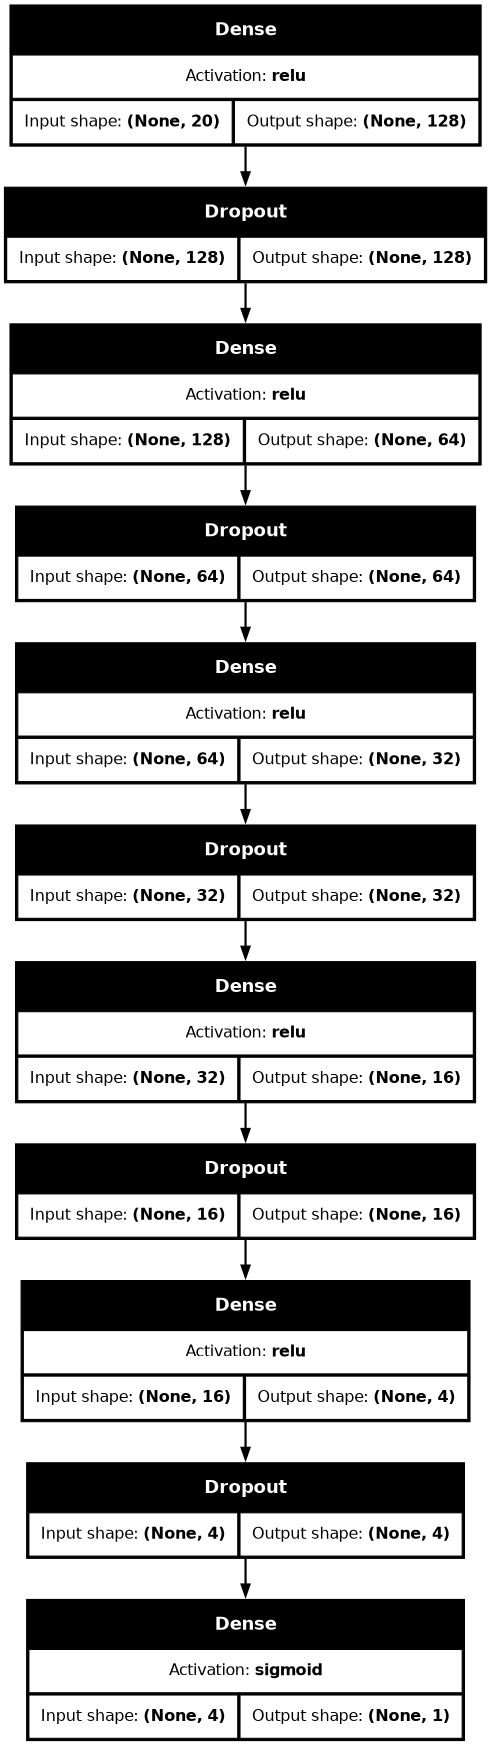

NameError: name 'KerasClassifier' is not defined

In [75]:
# Neural network (Keras) with two hidden layers (one-hot encoded)
def get_model(meta):
    model = keras.models.Sequential()
    
    # Input layer and first Dense layer
    model.add(layers.Input(shape=(meta["X_shape_"][1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    # Second Dense layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    # Third Dense layer
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Fourth Dense layer
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    # Fifth Dense layer
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model


display(keras.utils.plot_model(get_model({"X_shape_": processed_train.shape}),
                       show_shapes=True, show_layer_activations=True, dpi=80))


clf = KerasClassifier(
    get_model,
    loss="binary_crossentropy",
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_split=0.03,
    batch_size=8192,
    validation_batch_size=65536,
    epochs=50,
    verbose=1, # or 2
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3),
               keras.callbacks.EarlyStopping(patience=5, min_delta=0.00003)]
)

NN_model = make_pipeline(ColumnTransformer([('float', make_pipeline(PowerTransformer(),
                                                                 SimpleImputer(add_indicator=True)),
                                          float_features),
                                         ('cat', OneHotEncoder(drop='first',
                                                               sparse_output=False,
                                                               dtype=np.float32,
                                                               handle_unknown='infrequent_if_exist',
                                                               min_frequency=50),
                                          cat_features),
                                        ]),
                      StandardScaler(),
                      BaggingClassifier(clf, n_estimators=7, bootstrap=False))

cross_validate(NN_model, 'Keras')
#del model, clf


## Submission

In [43]:
# Make predictions on the test data
y_test_pred = dart_model.predict(processed_test)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': id,
    'class': y_test_pred
})

submission_df['class'].unique()

# Map the binary predictions to 'e' and 'p'
submission_df['class'] = np.where(submission_df['class'] == 1, 'p', 'e')

# Save the submission DataFrame to a CSV file
submission_df.to_csv('LightGBM_DART_model1_submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
